In [1]:
import os
from glob import glob
from tqdm import trange

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import Subset

from utils import calcuate, myenum, settings
from model import model

In [2]:
pos_paths = glob("../data/raw/position/*")

df = pd.DataFrame()
for pos_path in pos_paths:
    tmp = pd.read_csv(pos_path)
    tmp = calcuate.calc_velocity(tmp)
    df = pd.concat([df, tmp], axis=0)
df.reset_index(inplace=True, drop=True)
display(df.head())

,time,joint_Root.x,joint_Root.y,joint_Root.z,Hips.x,Hips.y,Hips.z,Spine.x,Spine.y,Spine.z,...,UpperLeg_R.vz,LowerLeg_R.vx,LowerLeg_R.vy,LowerLeg_R.vz,Foot_R.vx,Foot_R.vy,Foot_R.vz,Toes_R.vx,Toes_R.vy,Toes_R.vz
0,0.00000,0.0,0.0,0.0,-3.80622,93.0864,3.55978,-3.12544,108.80612,3.75790,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.03333,0.0,0.0,0.0,-3.80622,93.0864,3.55978,-3.17873,108.80849,3.74491,...,0.245125,-4.669967,-0.899490,8.590159,-8.159916,1.000000,-3.683468,-7.989199,2.581458,-2.392439
2,0.06667,0.0,0.0,0.0,-3.80622,93.0864,3.55978,-3.24294,108.81112,3.72724,...,0.196161,-6.149070,-1.027894,8.929514,-8.503899,1.144271,-3.857528,-8.341032,2.991902,-2.365927
3,0.10000,0.0,0.0,0.0,-3.80622,93.0864,3.55978,-3.32023,108.81393,3.70370,...,0.148815,-6.578458,-1.125413,8.499550,-9.199820,1.074707,-3.733273,-8.792679,2.282028,-2.796280
4,0.13333,0.0,0.0,0.0,-3.80622,93.0864,3.55978,-3.40801,108.81661,3.67852,...,0.115812,-3.737774,-1.087009,7.152715,-9.975998,0.781878,-3.351335,-9.242724,0.758776,-3.436544


In [4]:
#前処理
time = df["time"]
df_processed = df.iloc[:, 1:].apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

In [ ]:
input_columns = [
    "Head.x", "Head.y", "Head.z",
    "Hand_L.x", "Hand_L.y", "Hand_L.z",
    "Hand_R.x", "Hand_R.y", "Hand_R.z",
    "Head.vx", "Head.vy", "Head.vz",
    "Hand_L.vx", "Hand_L.vy", "Hand_L.vz",
    "Hand_R.vx", "Hand_R.vy", "Hand_R.vz",
]

output_columns = myenum.DefaultColumns.get_all_default_columns()

x, y = df_processed[input_columns], df[output_columns]
x = torch.tensor(x.values, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)
dataset = TensorDataset(x, y)

train_loss_history = []
valid_loss_history = []
epochs = 1000

kf = KFold(n_splits=5, shuffle=True, random_state=settings.seed)
cv_loss = []

for _fold, (train_index, test_index) in enumerate(kf.split(df)):
    # モデル定義
    mlp = model.MLP(input_size=len(input_columns), hidden_size=128, num_classes=len(output_columns))

    # 損失関数と最適化アルゴリズムの定義
    criterion = nn.MSELoss()
    optimizer = optim.Adam(mlp.parameters(), lr=0.001)

    train_dataset = Subset(dataset, train_index)
    train_dataloader = DataLoader(train_dataset, 64, shuffle=True)
    valid_dataset = Subset(dataset, test_index)
    valid_dataloader = DataLoader(valid_dataset, 64, shuffle=False)
    with trange(epochs) as t:
        for _ in t:
            t.set_description(f"fold {_fold}")
            train_loss = 0
            valid_loss = 0

            # 学習
            mlp.train()
            for inputs, labels in train_dataloader:
                outputs = mlp(inputs)
                loss = criterion(outputs, labels)
                # 勾配の初期化と逆伝播
                optimizer.zero_grad()
                loss.backward()
                # パラメータの更新
                optimizer.step()
                train_loss += loss.item()
            train_loss_history.append(train_loss / len(train_dataloader))

            # 推論
            mlp.eval()
            with torch.no_grad():
                for inputs, labels in valid_dataloader:
                    outputs = mlp(inputs)
                    loss = criterion(outputs, labels)
                    valid_loss += loss.item()
                valid_loss_history.append(valid_loss / len(valid_dataloader))
            t.set_postfix(train_loss=train_loss / len(train_dataloader), valid_loss=valid_loss / len(valid_dataloader))
        cv_loss.append(valid_loss / len(valid_dataloader))

fold 4: 100%|██████████| 1000/1000 [06:24<00:00,  2.60it/s, train_loss=11, valid_loss=13.4] 


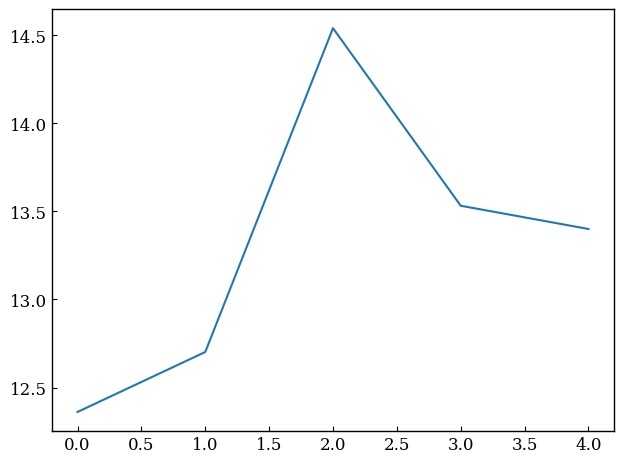

In [8]:
plt.plot(cv_loss)
plt.savefig(os.path.join(settings.RESULT_DIR, "output", "mlp-128-4cv_100epoch_processed.svg"));

/Users/riku-sh/Desktop/Bandai-Namco-Research-Motiondataset/utils/animation.py:153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label.drop(["joint_Root.x", "joint_Root.y", "joint_Root.z"], axis=1, inplace=True)
MovieWriter imagemagick unavailable; using Pillow instead.


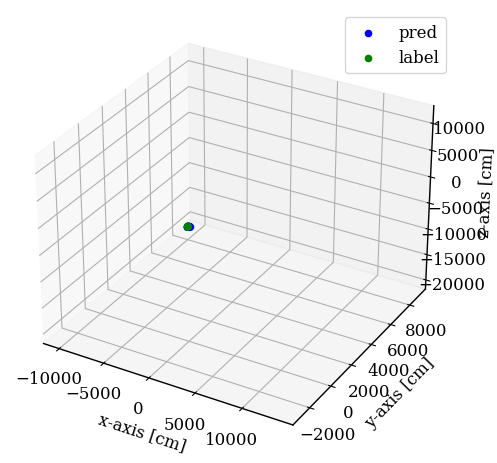

In [9]:
from utils import animation

filename = "dataset-1_bow_active_001_pos.csv"
filepath = os.path.join(settings.RAW_DIR, "position", filename)
df = pd.read_csv(filepath)
df = calcuate.calc_velocity(df)
df[myenum.DefaultColumns.get_all_default_columns()] = df[myenum.DefaultColumns.get_all_default_columns()].apply(
    lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
x = df[input_columns]
x = torch.tensor(x.values, dtype=torch.float32)

pred = mlp(x)

animation.create_git_combine(df[output_columns], pred, filename)

